# Insider Trading Signal Detection

## Ensemble
- CatBoost Classifier (profitable vs not)
- XGBoost Regressor (return prediction)
- LightGBM Regressor (complementary patterns)
- Ridge Regression (linear baseline)
- Quantile Regression (robust to outliers)
- Smart ensemble combining classifier + regressors

In [100]:
!pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, roc_curve, auc, confusion_matrix, classification_report
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostClassifier
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

CONFIG = {
    'file_path': 'insider_trades_with_returns.csv',
    'noise_filter_quantile': 0.20,
    'outlier_clip_lower': 0.01,
    'outlier_clip_upper': 0.995,
    'train_ratio': 0.8,
    'catboost_threshold': 0.5,
    'high_conviction_threshold': 0.6
}

In [101]:
# Data Loading and Cleaning
def clean_currency(x):
    if isinstance(x, str):
        # Fixed: Now handles both '>' and '<' symbols consistently
        x = x.replace('$', '').replace(',', '').replace('%', '').replace('+', '').strip()
        x = x.replace('>', '').replace('<', '')
        if x == '' or x == '-':
            return np.nan
    try:
        return float(x)
    except:
        return np.nan

df = pd.read_csv(CONFIG['file_path'])
print(f"Raw data: {len(df)} rows")

numeric_cols = ['last_price', 'Qty', 'shares_held', 'Owned', 'Value', 'return_30d_close', 'return_60d_close', 'return_90d_close']
for col in numeric_cols:
    if col in df.columns: df[col] = df[col].apply(clean_currency)

df['trade_date'] = pd.to_datetime(df['trade_date'], errors='coerce')
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
df = df.dropna(subset=['trade_date', 'return_30d_close'])
df = df.sort_values('trade_date').reset_index(drop=True)
print(f"After cleaning: {len(df)} rows")
print(f"Date range: {df['trade_date'].min()} to {df['trade_date'].max()}")

Raw data: 189483 rows
After cleaning: 120177 rows
Date range: 2002-05-02 00:00:00 to 2025-12-04 00:00:00


In [102]:
# Noise Filtering
print("="*50 + "\nNOISE FILTERING\n" + "="*50)
original_count = len(df)

min_value_threshold = df['Value'].quantile(CONFIG['noise_filter_quantile'])
df = df[df['Value'] >= min_value_threshold].copy()
print(f"After value filter (>= ${min_value_threshold:,.0f}): {len(df)} rows")

high_signal_titles = ['CEO', 'CFO', 'COO', 'CTO', 'Director', 'President', '10% Owner', 'Chairman', 'VP', 'General Counsel']
df['is_high_signal_title'] = df['Title'].fillna('').str.contains('|'.join(high_signal_titles), case=False, na=False).astype(int)

print(f"High-signal titles: {df['is_high_signal_title'].sum()} ({df['is_high_signal_title'].mean()*100:.1f}%)")
print(f"Removed: {original_count - len(df)} trades ({(original_count - len(df))/original_count*100:.1f}%)")

NOISE FILTERING
After value filter (>= $3,300): 96142 rows
High-signal titles: 30071 (31.3%)
Removed: 24035 trades (20.0%)


In [103]:
# Feature Engineering
print("="*50 + "\nFEATURE ENGINEERING\n" + "="*50)

df['shares_held'] = df['shares_held'].fillna(0)
df['last_price'] = df['last_price'].fillna(df['last_price'].median())
df['Qty'] = df['Qty'].fillna(0)
df['Value'] = df['Value'].fillna(0)
df['Owned'] = df['Owned'].fillna(0)


# 2. Market Context
try:
    import yfinance as yf
    print("Downloading SPY market data...")
    start_date = df['trade_date'].min() - pd.Timedelta(days=100)
    end_date = df['trade_date'].max() + pd.Timedelta(days=5)

    spy = yf.download('SPY', start=start_date, end=end_date, progress=False)['Close']
    spy = spy.reset_index()
    spy.columns = ['trade_date', 'spy_close']
    spy['trade_date'] = pd.to_datetime(spy['trade_date']).dt.tz_localize(None)

    # Calculate 50-day Moving Average
    spy['spy_50d_ma'] = spy['spy_close'].rolling(50).mean()
    spy['spy_ma_dist'] = (spy['spy_close'] / spy['spy_50d_ma']) - 1

    df = df.sort_values('trade_date')
    spy = spy.sort_values('trade_date').dropna()
    df = pd.merge_asof(df, spy[['trade_date', 'spy_ma_dist']], on='trade_date', direction='backward')

    # Fill missing market data with 0 (neutral)
    df['spy_ma_dist'] = df['spy_ma_dist'].fillna(0)
    print(f"Market Context Added: Mean MA Dist = {df['spy_ma_dist'].mean():.4f}")

except Exception as e:
    print(f"Skipping Market Context (yfinance error or not installed): {e}")
    df['spy_ma_dist'] = 0


# Trade conviction
df['portfolio_value'] = df['shares_held'] * df['last_price']
df['trade_conviction'] = (df['Value'] / (df['portfolio_value'] + 1)).clip(0, 100)

# Ownership change
df['ownership_change_pct'] = df['Qty'] / (df['shares_held'] + df['Qty'] + 1)

# Trade size vs insider average (no lookahead)
df = df.sort_values(['owner_name', 'trade_date'])
df['insider_avg_value'] = df.groupby('owner_name')['Value'].transform(lambda x: x.shift(1).expanding().mean())
df['value_vs_insider_avg'] = (df['Value'] / (df['insider_avg_value'] + 1)).fillna(1).clip(0, 50)

df = df.sort_values(['ticker', 'trade_date'])

def calculate_insider_cluster_no_lookahead(group):
    """Count unique insiders who traded this ticker in the prior 7 days (excluding current day)"""
    result = []
    for idx, row in group.iterrows():
        current_date = row['trade_date']
        # Look back 7 days, excluding current day
        mask = (group['trade_date'] >= current_date - pd.Timedelta(days=7)) & \
               (group['trade_date'] < current_date)
        prior_insiders = group.loc[mask, 'owner_name'].nunique()
        result.append(prior_insiders)
    return pd.Series(result, index=group.index)

# This is slower but correct - no lookahead bias
print("  Calculating insider_cluster (no lookahead)...")
df['insider_cluster'] = df.groupby('ticker', group_keys=False).apply(calculate_insider_cluster_no_lookahead)

# Rolling ticker activity
def calculate_rolling_trades(group):
    s = pd.Series(1, index=group['trade_date'])
    counts = s.rolling('30D', closed='left').count()
    return pd.Series(counts.values, index=group.index).fillna(0)

df = df.sort_values(['ticker', 'trade_date'])
df['ticker_trade_count_30d'] = df.groupby('ticker', group_keys=False).apply(calculate_rolling_trades).astype(int)

# Days since last trade
df = df.sort_values(['owner_name', 'trade_date'])
df['prev_trade_date'] = df.groupby('owner_name')['trade_date'].shift(1)
df['days_since_last_trade'] = (df['trade_date'] - df['prev_trade_date']).dt.days.fillna(365).clip(0, 365)

df = df.sort_values(['ticker', 'trade_date'])

df['price_momentum_30d'] = df.groupby('ticker', group_keys=False)['last_price'].transform(
    lambda x: x.pct_change(periods=30)
)
# Fill NaN with 0 (for stocks without 30 days of history)
df['price_momentum_30d'] = df['price_momentum_30d'].fillna(0).clip(-1, 1)

# Create a "buying the dip" indicator (insider buying after significant price drop)
df['buying_the_dip'] = ((df['price_momentum_30d'] < -0.10)).astype(int)

df = df.sort_values('trade_date').reset_index(drop=True)

new_features = ['trade_conviction', 'ownership_change_pct', 'value_vs_insider_avg', 'insider_cluster', 'ticker_trade_count_30d', 'days_since_last_trade', 'is_high_signal_title', 'spy_ma_dist', 'price_momentum_30d', 'buying_the_dip']
for feat in new_features:
    print(f"  {feat}: mean={df[feat].mean():.3f}, std={df[feat].std():.3f}")

FEATURE ENGINEERING
Market Context Added: Mean MA Dist = 0.0054
  Calculating insider_cluster (no lookahead)...
  trade_conviction: mean=0.547, std=6.048
  ownership_change_pct: mean=0.112, std=0.154
  value_vs_insider_avg: mean=1.301, std=3.055
  insider_cluster: mean=0.896, std=2.547
  ticker_trade_count_30d: mean=5.369, std=25.786
  days_since_last_trade: mean=182.391, std=160.698
  is_high_signal_title: mean=0.313, std=0.464
  spy_ma_dist: mean=0.005, std=0.048
  price_momentum_30d: mean=0.018, std=0.276
  buying_the_dip: mean=0.126, std=0.331


In [104]:
# Target Preparation & Splitting (Leakage Fix)
print("="*50 + "\nTARGET PREP & SPLIT (NO LEAKAGE)\n" + "="*50)

# 1. Define Split Point First
train_size = int(len(df) * CONFIG['train_ratio'])
test_start_date = df.iloc[train_size]['trade_date']
train_cutoff_date = df.iloc[train_size]['trade_date']
print(f"Split Date: {train_cutoff_date}")

# 2. Calculate Clipping Statistics on TRAIN DATA ONLY
train_slice = df.iloc[:train_size]
# HARDER
lower_bound = train_slice['return_30d_close'].quantile(CONFIG['outlier_clip_lower'])
upper_bound = train_slice['return_30d_close'].quantile(CONFIG['outlier_clip_upper'])

print(f"Clipping Thresholds (derived from train): [{lower_bound:.2%}, {upper_bound:.2%}]")

# 3. Apply to Whole Dataset
df['return_30d_clipped'] = df['return_30d_close'].clip(lower_bound, upper_bound)
df['is_profitable'] = (df['return_30d_close'] > 0).astype(int) # Use raw returns for binary truth

# 4. Insider Track Record (Requires full history, but uses shift(1) so no leakage)
df = df.sort_values(['owner_name', 'trade_date'])
df['insider_hit_rate'] = df.groupby('owner_name')['is_profitable'].transform(
    lambda x: x.shift(1).expanding().mean()
).fillna(0.5)
df['insider_trade_count'] = df.groupby('owner_name').cumcount()
df = df.sort_values('trade_date').reset_index(drop=True)

# 5. Final Split
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

# Validation Split (from end of train)
valid_train_mask = train_df['trade_date'] < (test_start_date - pd.Timedelta(days=30))
train_df = train_df[valid_train_mask]

# Create Validation Split (THIS WAS MISSING)
# Take last 10% of the *purged* train data for validation
val_split_idx = int(len(train_df) * 0.90)

val_df = train_df.iloc[val_split_idx:].copy()
train_df = train_df.iloc[:val_split_idx].copy()

# Prepare Feature Lists (Add new market feature)
cat_features = ['ticker', 'company_name', 'owner_name', 'Title', 'transaction_type']
num_features = ['last_price', 'Qty', 'shares_held', 'Owned', 'Value',
                'trade_conviction', 'ownership_change_pct', 'value_vs_insider_avg',
                'insider_cluster', 'ticker_trade_count_30d', 'days_since_last_trade',
                'is_high_signal_title', 'insider_hit_rate', 'insider_trade_count',
                'spy_ma_dist', 'price_momentum_30d', 'buying_the_dip']

for col in cat_features:
    train_df[col] = train_df[col].fillna('Unknown').astype(str)
    test_df[col] = test_df[col].fillna('Unknown').astype(str)

print(f"Train: {len(train_df)} | Test: {len(test_df)}")

TARGET PREP & SPLIT (NO LEAKAGE)
Split Date: 2023-08-17 00:00:00
Clipping Thresholds (derived from train): [-41.82%, 90.03%]
Train: 68613 | Test: 19229


In [105]:
# Prepare feature matrices CTL Z for this
print("="*50 + "\nPREPARING FEATURES\n" + "="*50)

# 1. Define Feature Lists
num_features = ['last_price', 'Qty', 'shares_held', 'Owned', 'Value',
                'trade_conviction', 'ownership_change_pct', 'value_vs_insider_avg',
                'insider_cluster', 'ticker_trade_count_30d', 'days_since_last_trade',
                'is_high_signal_title', 'insider_hit_rate', 'insider_trade_count',
                'spy_ma_dist','price_momentum_30d', 'buying_the_dip']
all_features = cat_features + num_features

# 2. Create Matrices from the ALREADY SPLIT Dataframes

# --- Numeric Features (For XGBoost, LightGBM, Ridge) ---
# Train
X_train_num = train_df[num_features].fillna(0)
y_train_reg = train_df['return_30d_clipped']

# Validation (Use val_df!)
X_val_num   = val_df[num_features].fillna(0)
y_val_reg   = val_df['return_30d_clipped']

# Test
X_test_num  = test_df[num_features].fillna(0)
y_test_reg  = test_df['return_30d_clipped']

# --- Scaled Features (For Ridge/Linear Models) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_val_scaled   = scaler.transform(X_val_num)   # Scale Validation too
X_test_scaled  = scaler.transform(X_test_num)

# --- Categorical/All Features (For CatBoost) ---
# Train
X_train_cat = train_df[all_features].copy()
y_train_clf = train_df['is_profitable']

# Validation
X_val_cat   = val_df[all_features].copy()
y_val_clf   = val_df['is_profitable']

# Test
X_test_cat  = test_df[all_features].copy()
y_test_clf  = test_df['is_profitable']

# Fill NaNs in numeric columns for CatBoost (leave text cols as strings)
for col in num_features:
    X_train_cat[col] = X_train_cat[col].fillna(0)
    X_val_cat[col]   = X_val_cat[col].fillna(0)
    X_test_cat[col]  = X_test_cat[col].fillna(0)

X_train_final = X_train_num
y_train_final = y_train_reg

X_val_final   = X_val_num
y_val_final   = y_val_reg

print(f"Numeric features: {len(num_features)}")
print(f"Total features: {len(all_features)}")
print(f"Train Shape: {X_train_num.shape} | Val Shape: {X_val_num.shape} | Test Shape: {X_test_num.shape}")

PREPARING FEATURES
Numeric features: 17
Total features: 22
Train Shape: (68613, 17) | Val Shape: (7624, 17) | Test Shape: (19229, 17)


In [106]:
# Model 1: XGBoost Regressor
print("="*50 + "\nMODEL 1: XGBoost Regressor\n" + "="*50)

xgb_model = xgb.XGBRegressor(
    objective='reg:absoluteerror', n_estimators=300, max_depth=5, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0,
    min_child_weight=10, early_stopping_rounds=30, random_state=42
)
xgb_model.fit(X_train_final, y_train_final, eval_set=[(X_val_final, y_val_final)], verbose=False)

xgb_preds = xgb_model.predict(X_test_num)
xgb_mae = mean_absolute_error(y_test_reg, xgb_preds)
print(f"XGBoost MAE: {xgb_mae:.4f} | Best iter: {xgb_model.best_iteration}")

MODEL 1: XGBoost Regressor
XGBoost MAE: 0.1207 | Best iter: 299


In [107]:
# Model 2: LightGBM Regressor
print("="*50 + "\nMODEL 2: LightGBM Regressor\n" + "="*50)

from lightgbm import early_stopping, log_evaluation



lgbm_model = LGBMRegressor(
    objective='mae',
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    min_child_samples=30,
    random_state=42,
    verbosity=-1
)

lgbm_model.fit(
    X_train_final, y_train_final, eval_set=[(X_val_final, y_val_final)],
    callbacks=[early_stopping(30, verbose=False), log_evaluation(0)]
)

lgbm_preds = lgbm_model.predict(X_test_num)
lgbm_mae = mean_absolute_error(y_test_reg, lgbm_preds)
print(f"LightGBM MAE: {lgbm_mae:.4f} | Best iter: {lgbm_model.best_iteration_}")

MODEL 2: LightGBM Regressor
LightGBM MAE: 0.1208 | Best iter: 140


In [108]:
# Model 3: Ridge Regression (Linear)
print("="*50 + "\nMODEL 3: Ridge Regression\n" + "="*50)

ridge_model = Ridge(alpha=10.0)
ridge_model.fit(X_train_scaled, y_train_final)

ridge_preds = ridge_model.predict(X_test_scaled)
ridge_mae = mean_absolute_error(y_test_reg, ridge_preds)
print(f"Ridge MAE: {ridge_mae:.4f}")

# Show coefficients
ridge_coef = pd.DataFrame({'Feature': num_features, 'Coefficient': ridge_model.coef_})
ridge_coef['Abs_Coef'] = ridge_coef['Coefficient'].abs()
ridge_coef = ridge_coef.sort_values('Abs_Coef', ascending=False)
print("\nTop 5 Ridge Coefficients:")
print(ridge_coef.head().to_string(index=False))

MODEL 3: Ridge Regression
Ridge MAE: 0.1220

Top 5 Ridge Coefficients:
              Feature  Coefficient  Abs_Coef
     insider_hit_rate     0.017580  0.017580
          spy_ma_dist    -0.008046  0.008046
 ownership_change_pct     0.005034  0.005034
days_since_last_trade     0.004526  0.004526
   price_momentum_30d    -0.003144  0.003144


In [109]:
# Model 4: Quantile Regression (Median - robust to outliers)
print("="*50 + "\nMODEL 4: Quantile Regression (Median)\n" + "="*50)

quantile_model = GradientBoostingRegressor(
    loss='quantile',
    alpha=0.5,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    min_samples_leaf=30,
    subsample=0.8,
    random_state=42
)

quantile_model.fit(X_train_final, y_train_final, )

quantile_preds = quantile_model.predict(X_test_num)
quantile_mae = mean_absolute_error(y_test_reg, quantile_preds)
print(f"Quantile (Median) MAE: {quantile_mae:.4f}")

MODEL 4: Quantile Regression (Median)
Quantile (Median) MAE: 0.1207


In [110]:
# Model 5: CatBoost Classifier
print("="*50 + "\nMODEL 5: CatBoost Classifier\n" + "="*50)

# 1. Define Categorical Columns (Must match what you used in Feature Prep)
cat_features = ['ticker', 'company_name', 'owner_name', 'Title', 'transaction_type']

# 2. SAFETY CLEANING: Force-fill NaNs and convert to String immediately before training
print("Sanitizing categorical data...")
for col in cat_features:
    # Train
    X_train_cat[col] = X_train_cat[col].fillna('Unknown').astype(str)
    # Val
    X_val_cat[col]   = X_val_cat[col].fillna('Unknown').astype(str)
    # Test
    X_test_cat[col]  = X_test_cat[col].fillna('Unknown').astype(str)

cat_model = CatBoostClassifier(
    iterations=500, learning_rate=0.03, depth=5, l2_leaf_reg=10,
    min_data_in_leaf=30, cat_features=cat_features, verbose=100,
    random_seed=42, early_stopping_rounds=50, use_best_model=True
)
cat_model.fit(X_train_cat, y_train_clf,
    eval_set=(X_val_cat, y_val_clf), verbose=100)

cat_probs = cat_model.predict_proba(X_test_cat)[:, 1]
cat_preds = (cat_probs > 0.5).astype(int)
cat_acc = (cat_preds == y_test_clf).mean()
print(f"\nCatBoost Accuracy: {cat_acc:.4f} | Best iter: {cat_model.best_iteration_}")

MODEL 5: CatBoost Classifier
Sanitizing categorical data...
0:	learn: 0.6912738	test: 0.6922178	best: 0.6922178 (0)	total: 23.7ms	remaining: 11.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6798861084
bestIteration = 26

Shrink model to first 27 iterations.

CatBoost Accuracy: 0.5632 | Best iter: 26


In [111]:
# Compare Regressor Performance
print("="*50 + "\nREGRESSOR COMPARISON\n" + "="*50)

regressor_results = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'Ridge', 'Quantile (Median)'],
    'MAE': [xgb_mae, lgbm_mae, ridge_mae, quantile_mae]
}).sort_values('MAE')

print(regressor_results.to_string(index=False))
print(f"\nBest Regressor: {regressor_results.iloc[0]['Model']} (MAE: {regressor_results.iloc[0]['MAE']:.4f})")

REGRESSOR COMPARISON
            Model      MAE
Quantile (Median) 0.120720
          XGBoost 0.120736
         LightGBM 0.120838
            Ridge 0.121952

Best Regressor: Quantile (Median) (MAE: 0.1207)


In [112]:
# Create Ensemble Predictions
print("="*50 + "\nENSEMBLE CONSTRUCTION\n" + "="*50)

test_df = test_df.copy()

# Store individual predictions
test_df['cat_prob'] = cat_probs
test_df['xgb_pred'] = xgb_preds
test_df['lgbm_pred'] = lgbm_preds
test_df['ridge_pred'] = ridge_preds
test_df['quantile_pred'] = quantile_preds

# Ensemble regression: average of all regressors
test_df['ensemble_reg_pred'] = (xgb_preds + lgbm_preds + ridge_preds + quantile_preds) / 4

# Weighted ensemble (weight by inverse MAE)
total_inv_mae = (1/xgb_mae + 1/lgbm_mae + 1/ridge_mae + 1/quantile_mae)
w_xgb = (1/xgb_mae) / total_inv_mae
w_lgbm = (1/lgbm_mae) / total_inv_mae
w_ridge = (1/ridge_mae) / total_inv_mae
w_quantile = (1/quantile_mae) / total_inv_mae

test_df['weighted_reg_pred'] = (w_xgb * xgb_preds + w_lgbm * lgbm_preds +
                                 w_ridge * ridge_preds + w_quantile * quantile_preds)

print(f"Ensemble weights (by inverse MAE):")
print(f"  XGBoost: {w_xgb:.3f}")
print(f"  LightGBM: {w_lgbm:.3f}")
print(f"  Ridge: {w_ridge:.3f}")
print(f"  Quantile: {w_quantile:.3f}")

# Check ensemble MAE
ensemble_mae = mean_absolute_error(y_test_reg, test_df['ensemble_reg_pred'])
weighted_mae = mean_absolute_error(y_test_reg, test_df['weighted_reg_pred'])
print(f"\nSimple Ensemble MAE: {ensemble_mae:.4f}")
print(f"Weighted Ensemble MAE: {weighted_mae:.4f}")

ENSEMBLE CONSTRUCTION
Ensemble weights (by inverse MAE):
  XGBoost: 0.251
  LightGBM: 0.250
  Ridge: 0.248
  Quantile: 0.251

Simple Ensemble MAE: 0.1207
Weighted Ensemble MAE: 0.1207


In [113]:
# Strategy Construction
print("="*50 + "\nSTRATEGY CONSTRUCTION\n" + "="*50)

median_conviction = test_df['trade_conviction'].median()
reg_pred_30th = np.percentile(test_df['weighted_reg_pred'], 30)

# Individual model signals
test_df['catboost_signal'] = (test_df['cat_prob'] > 0.5).astype(int)
test_df['xgb_signal'] = (test_df['xgb_pred'] > 0).astype(int)
test_df['lgbm_signal'] = (test_df['lgbm_pred'] > 0).astype(int)

# ENSEMBLE STRATEGIES

# Strategy 1: Classifier + Any Regressor Agrees
test_df['clf_plus_reg_signal'] = (
    (test_df['cat_prob'] > 0.5) &
    (test_df['weighted_reg_pred'] > 0)
).astype(int)

# Strategy 2: Classifier + Regressor + Above Average Prediction
test_df['smart_ensemble_signal'] = (
    (test_df['cat_prob'] > 0.55) &
    (test_df['weighted_reg_pred'] > 0) &
    (test_df['weighted_reg_pred'] > reg_pred_30th)
).astype(int)

# Strategy 3: High Conviction Ensemble
test_df['high_conv_ensemble_signal'] = (
    (test_df['cat_prob'] > 0.6) &
    (test_df['weighted_reg_pred'] > reg_pred_30th) &
    (test_df['trade_conviction'] > median_conviction)
).astype(int)

# Strategy 4: All Models Agree (consensus)
test_df['consensus_signal'] = (
    (test_df['cat_prob'] > 0.5) &
    (test_df['xgb_pred'] > 0) &
    (test_df['lgbm_pred'] > 0) &
    (test_df['quantile_pred'] > 0)
).astype(int)

# Strategy 5: Ultra Selective Ensemble
test_df['ultra_ensemble_signal'] = (
    (test_df['cat_prob'] > 0.65) &
    (test_df['weighted_reg_pred'] > np.percentile(test_df['weighted_reg_pred'], 50)) &
    (test_df['trade_conviction'] > median_conviction) &
    (test_df['is_high_signal_title'] == 1)
).astype(int)

strategies = ['catboost', 'xgb', 'lgbm', 'clf_plus_reg', 'smart_ensemble',
              'high_conv_ensemble', 'consensus', 'ultra_ensemble']

print("Strategy trade counts:")
for strat in strategies:
    n = test_df[f'{strat}_signal'].sum()
    pct = test_df[f'{strat}_signal'].mean() * 100
    print(f"  {strat}: {n} trades ({pct:.1f}%)")

STRATEGY CONSTRUCTION
Strategy trade counts:
  catboost: 14526 trades (75.5%)
  xgb: 16341 trades (85.0%)
  lgbm: 16817 trades (87.5%)
  clf_plus_reg: 13610 trades (70.8%)
  smart_ensemble: 5671 trades (29.5%)
  high_conv_ensemble: 1068 trades (5.6%)
  consensus: 12709 trades (66.1%)
  ultra_ensemble: 18 trades (0.1%)


In [114]:
# Calculate Strategy Returns
print("="*50 + "\nSTRATEGY PERFORMANCE\n" + "="*50)

actual_returns = test_df['return_30d_clipped']

for strat in strategies:
    test_df[f'{strat}_ret'] = test_df[f'{strat}_signal'] * actual_returns
    test_df[f'cum_{strat}'] = test_df[f'{strat}_ret'].cumsum()

print("\nPerformance Summary:")
print("-" * 85)
print(f"{'Strategy':<22} | {'Trades':>7} | {'Total Ret':>10} | {'Avg Ret':>9} | {'Win Rate':>8}")
print("-" * 85)

results = []
for strat in strategies:
    n_trades = test_df[f'{strat}_signal'].sum()
    total_ret = test_df[f'{strat}_ret'].sum()
    avg_ret = test_df.loc[test_df[f'{strat}_signal'] == 1, 'return_30d_clipped'].mean() if n_trades > 0 else 0
    win_rate = (test_df.loc[test_df[f'{strat}_signal'] == 1, 'return_30d_clipped'] > 0).mean() if n_trades > 0 else 0
    results.append({'Strategy': strat, 'Trades': n_trades, 'Total': total_ret, 'Avg': avg_ret, 'Win': win_rate})
    print(f"{strat.upper():<22} | {n_trades:>7} | {total_ret:>9.2%} | {avg_ret:>8.2%} | {win_rate:>7.1%}")

results_df = pd.DataFrame(results)

STRATEGY PERFORMANCE

Performance Summary:
-------------------------------------------------------------------------------------
Strategy               |  Trades |  Total Ret |   Avg Ret | Win Rate
-------------------------------------------------------------------------------------
CATBOOST               |   14526 | 66267.24% |    4.56% |   59.0%
XGB                    |   16341 | 76847.16% |    4.70% |   59.2%
LGBM                   |   16817 | 80388.90% |    4.78% |   59.2%
CLF_PLUS_REG           |   13610 | 64179.28% |    4.72% |   59.5%
SMART_ENSEMBLE         |    5671 | 31968.72% |    5.64% |   63.4%
HIGH_CONV_ENSEMBLE     |    1068 |  7702.80% |    7.21% |   66.6%
CONSENSUS              |   12709 | 61294.21% |    4.82% |   59.9%
ULTRA_ENSEMBLE         |      18 |   166.77% |    9.27% |   88.9%


Fetching S&P 500 data from 2023-08-17 to 2026-02-02...


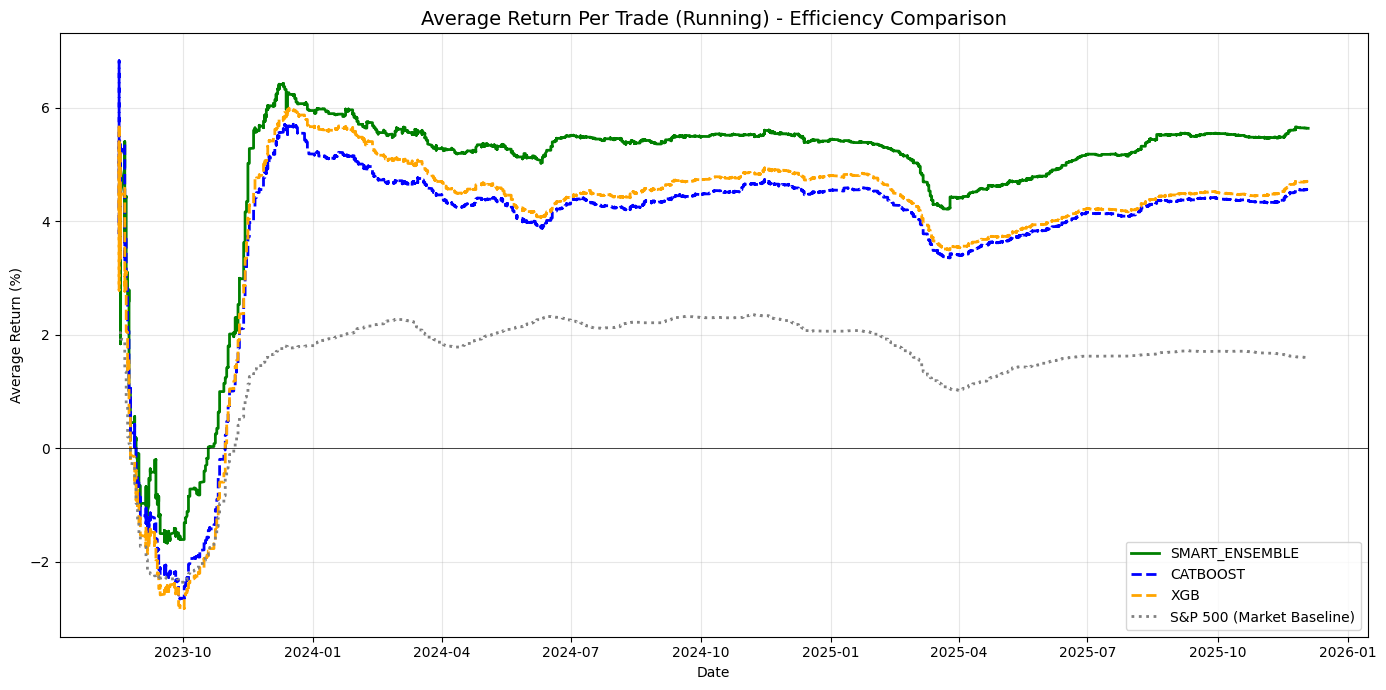

In [115]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. SETUP S&P 500 BENCHMARK
# ==========================================
start_date = test_df['trade_date'].min()
end_date = test_df['trade_date'].max() + pd.Timedelta(days=60)

print(f"Fetching S&P 500 data from {start_date.date()} to {end_date.date()}...")
spy = yf.download('SPY', start=start_date, end=end_date, progress=False)

# 1. Flatten MultiIndex if it exists
if isinstance(spy.columns, pd.MultiIndex):
    # Try to extract 'Close' or 'Adj Close'
    if 'Close' in spy.columns.get_level_values(0):
        spy = spy.xs('Close', level=0, axis=1)
    elif 'Adj Close' in spy.columns.get_level_values(0):
        spy = spy.xs('Adj Close', level=0, axis=1)
    else:
        spy = spy.iloc[:, 0].to_frame()

if len(spy.columns) == 1:
    spy.columns = ['Close']
elif 'Close' not in spy.columns and 'Adj Close' in spy.columns:
    spy = spy.rename(columns={'Adj Close': 'Close'})

# Calculate Future 30-Day Return (Approx 21 trading days)
# (Price T+30 / Price T) - 1
spy['sp500_ret'] = spy['Close'].shift(-21) / spy['Close'] - 1

# Map SPY returns to the specific trade dates in test_df
spy.index = spy.index.normalize() # Remove time component
temp_dates = pd.to_datetime(test_df['trade_date']).dt.normalize()

# Create Benchmark Columns in test_df
test_df['sp500_ret'] = temp_dates.map(spy['sp500_ret']).fillna(0)
test_df['sp500_signal'] = 1 # Dummy signal: "Market Baseline" trades on every row

# ==========================================
# 2. PLOTTING
# ==========================================
plt.figure(figsize=(14, 7))

min_trades = 25

# Added 'sp500' to the list
strategies = [
    ('smart_ensemble', 'green', '-'),
    ('catboost', 'blue', '--'),
    ('xgb', 'orange', '--'),
    ('sp500', 'gray', ':')
]

for strat, color, style in strategies:
    # Check if strategy columns exist before plotting
    if f'{strat}_signal' not in test_df.columns:
        print(f"Skipping {strat}: Columns not found.")
        continue

    # Calculate Running Average Return Per Trade
    n_trades_cumsum = test_df[f'{strat}_signal'].cumsum()

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        avg_return_per_trade = test_df[f'{strat}_ret'].cumsum() / n_trades_cumsum

    # Mask out early unstable period (noise)
    avg_return_per_trade[n_trades_cumsum < min_trades] = np.nan

    # Create label
    label = "S&P 500 (Market Baseline)" if strat == 'sp500' else strat.upper()

    plt.plot(test_df['trade_date'], avg_return_per_trade * 100, # converted to %
             label=label, color=color, linestyle=style, linewidth=2)

plt.axhline(y=0, color='black', linewidth=0.5)
plt.title('Average Return Per Trade (Running) - Efficiency Comparison', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Average Return (%)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('return_per_trade_with_spy.png', dpi=150)
plt.show()

REALISTIC PORTFOLIO SIMULATION (EFFICIENT)


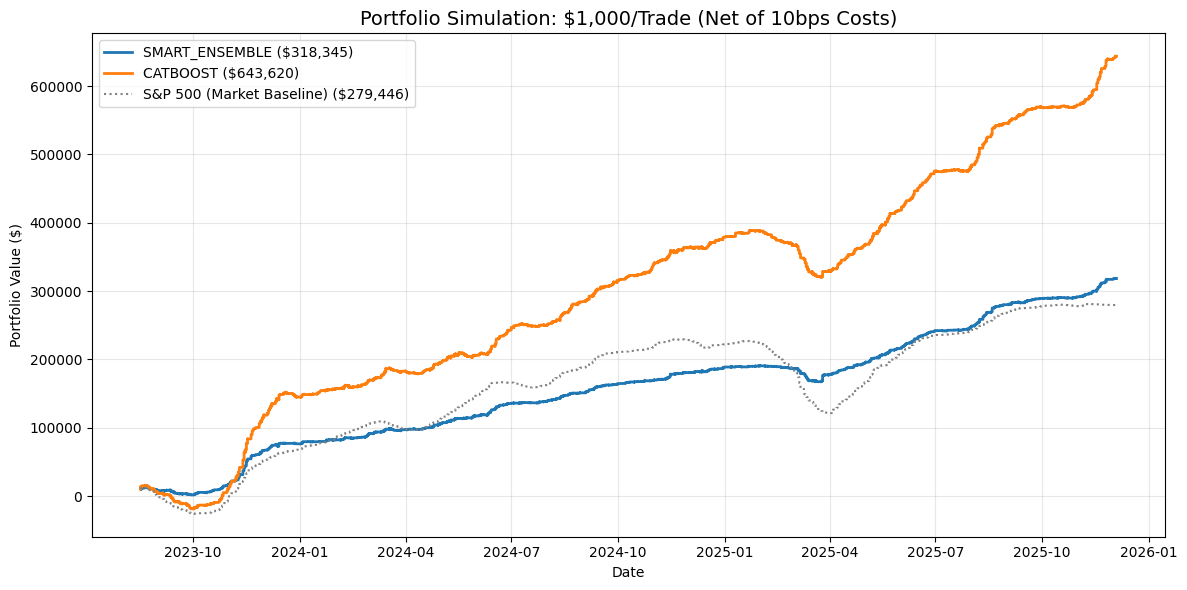


Simulation Results (Net of Costs):
      Strategy  Trades Final Equity Total Return Win Rate
          lgbm   16817  $780,254.99     7702.55%    58.4%
           xgb   16341  $745,789.59     7357.90%    58.4%
      catboost   14526  $643,620.43     6336.20%    58.2%
smart_ensemble    5671  $318,345.23     3083.45%    62.8%
         sp500   19229  $279,446.14     2694.46%    68.9%


In [116]:
# Strategy Performance with Equity Curve & Costs
print("="*50 + "\PORTFOLIO SIMULATION\n" + "="*50)

# 1. Simulation Parameters
INITIAL_CAPITAL = 10000
TRADE_ALLOCATION = 1000  # Invest $1,000 per signal
COST_BPS = 0.001         # (slippage + comms)

# 2. Helper to calculate equity curve
def calculate_equity(signal_series, returns_series):
    # Net Return = Raw Return - Transaction Cost (entry + exit)
    net_returns = returns_series - (COST_BPS * 2)

    # PnL = Allocation * Net Return * Signal (0 or 1)
    trade_pnl = TRADE_ALLOCATION * net_returns * signal_series

    # Cumulative Sum + Initial Capital
    equity_curve = INITIAL_CAPITAL + trade_pnl.cumsum()
    return equity_curve, trade_pnl

# 3. Define Strategies to Simulate
# We assume these columns exist in test_df from previous cells
base_strategies = ['smart_ensemble', 'catboost', 'xgb', 'lgbm']
sim_list = [s for s in base_strategies if f'{s}_signal' in test_df.columns]

# Add Benchmark if available (from the previous cell)
if 'sp500_ret' in test_df.columns:
    sim_list.append('sp500')
else:
    print("Warning: 'sp500_ret' not found. Run the previous plotting cell first.")

# 4. Run Simulation Loop
plt.figure(figsize=(12, 6))
summary_stats = []

for strat in sim_list:
    # A. Select Columns based on Strategy vs Benchmark
    if strat == 'sp500':
        signal_col = 'sp500_signal'
        return_col = 'sp500_ret'
        display_name = "S&P 500 (Market Baseline)"
        color = 'gray'
        style = ':'
        linewidth = 1.5
    else:
        signal_col = f'{strat}_signal'
        return_col = 'return_30d_clipped'
        display_name = strat.upper()
        color = None #
        style = '-'
        linewidth = 2

    # B. Calculate Equity
    equity, pnl = calculate_equity(test_df[signal_col], test_df[return_col])
    test_df[f'equity_{strat}'] = equity

    # C. Statistics
    final_equity = equity.iloc[-1]
    total_return_pct = (final_equity - INITIAL_CAPITAL) / INITIAL_CAPITAL
    n_trades = test_df[signal_col].sum()
    win_rate = (pnl > 0).sum() / n_trades if n_trades > 0 else 0

    summary_stats.append({
        'Strategy': strat,
        'Trades': int(n_trades),
        'Final Equity': final_equity,
        'Total Return': total_return_pct,
        'Win Rate': win_rate
    })

    # Plot
    if strat in ['sp500', 'smart_ensemble', 'catboost']:
        plt.plot(test_df['trade_date'], equity,
                 label=f"{display_name} (${final_equity:,.0f})",
                 color=color, linestyle=style, linewidth=linewidth)

# 5. Formatting & Output
plt.title(f'Portfolio Simulation: ${TRADE_ALLOCATION:,.0f}/Trade (Net of {COST_BPS*10000:.0f}bps Costs)', fontsize=14)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('portfolio_simulation.png')
plt.show()

# Display Stats Table
stats_df = pd.DataFrame(summary_stats).sort_values('Final Equity', ascending=False)
print("\nSimulation Results (Net of Costs):")
print(stats_df.to_string(index=False, formatters={
    'Final Equity': '${:,.2f}'.format,
    'Total Return': '{:.2%}'.format,
    'Win Rate': '{:.1%}'.format
}))

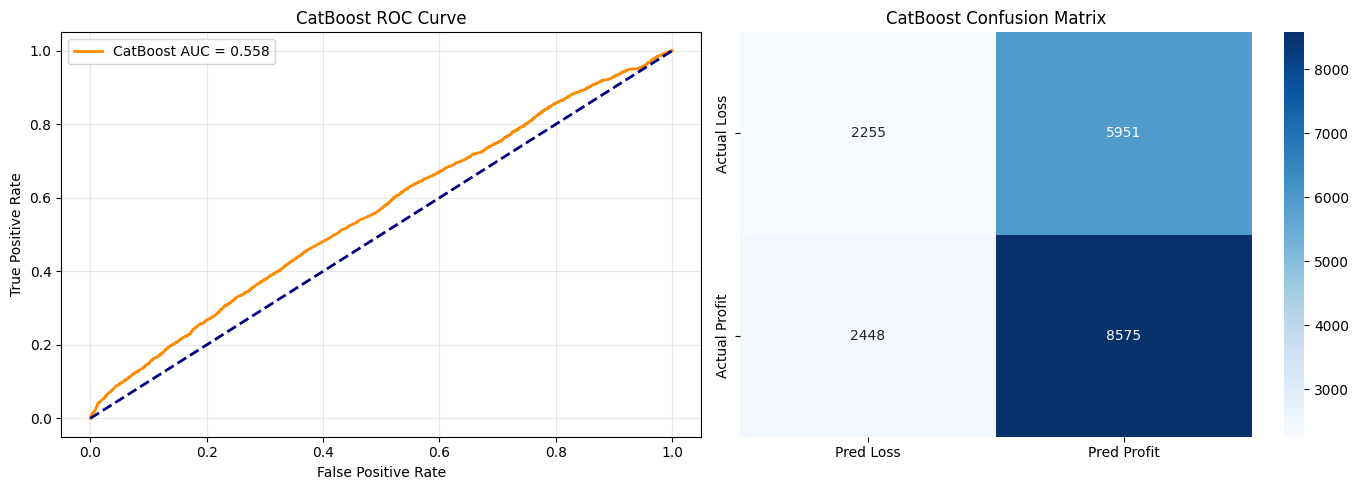

In [117]:
# ROC Curve and Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

fpr, tpr, _ = roc_curve(y_test_clf, cat_probs)
roc_auc = auc(fpr, tpr)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'CatBoost AUC = {roc_auc:.3f}')
axes[0].plot([0, 1], [0, 1], 'navy', lw=2, linestyle='--')
axes[0].set_xlabel('False Positive Rate'); axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('CatBoost ROC Curve'); axes[0].legend(); axes[0].grid(alpha=0.3)

cm = confusion_matrix(y_test_clf, cat_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Pred Loss', 'Pred Profit'], yticklabels=['Actual Loss', 'Actual Profit'])
axes[1].set_title('CatBoost Confusion Matrix')
plt.tight_layout(); plt.savefig('roc_cm.png', dpi=150); plt.show()

FEATURE IMPORTANCE ANALYSIS

--- XGBoost Feature Importance (Top 10) ---
               Feature  Importance
      insider_hit_rate    0.137384
 days_since_last_trade    0.108875
ticker_trade_count_30d    0.088013
           spy_ma_dist    0.078590
       insider_cluster    0.078193
            last_price    0.065084
        buying_the_dip    0.055635
    price_momentum_30d    0.053791
   insider_trade_count    0.053554
  ownership_change_pct    0.040510

--- LightGBM Feature Importance (Top 10) ---
               Feature  Importance
           spy_ma_dist         574
ticker_trade_count_30d         473
            last_price         324
    price_momentum_30d         235
   insider_trade_count         226
      insider_hit_rate         196
 days_since_last_trade         190
       insider_cluster         175
                   Qty         146
                 Value         140

--- CatBoost Feature Importance (Top 10) ---
               Feature  Importance
                ticker   39.13

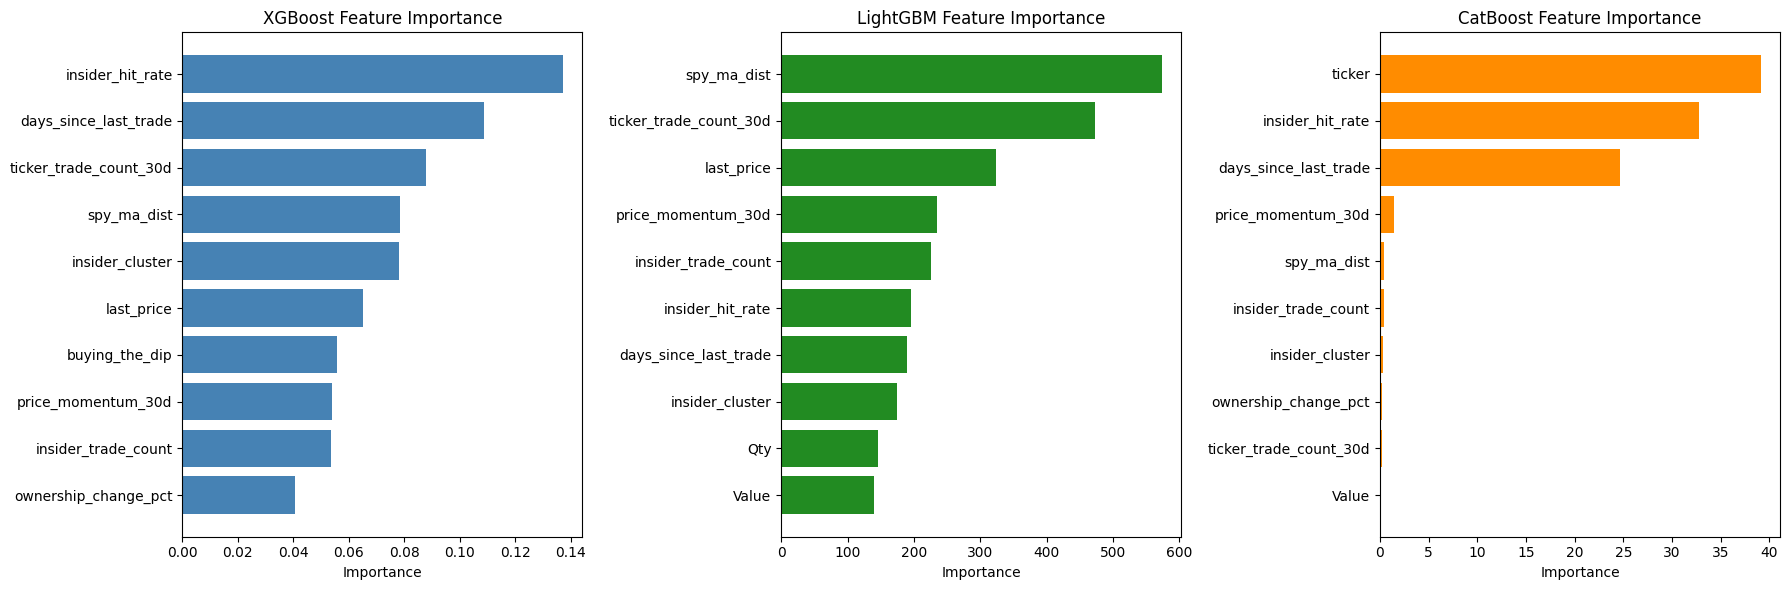


--- Feature Importance Consensus (Average Rank) ---
               Feature  XGB_Rank  LGBM_Rank  Avg_Rank
           spy_ma_dist         4          1       2.5
ticker_trade_count_30d         3          2       2.5
      insider_hit_rate         1          6       3.5
 days_since_last_trade         2          7       4.5
            last_price         6          3       4.5
    price_momentum_30d         8          4       6.0
       insider_cluster         5          8       6.5
   insider_trade_count         9          5       7.0
                   Qty        11          9      10.0
           shares_held        12         11      11.5

(Lower average rank = more important across models)


In [118]:
print("="*50 + "\nFEATURE IMPORTANCE ANALYSIS\n" + "="*50)

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': num_features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n--- XGBoost Feature Importance (Top 10) ---")
print(xgb_importance.head(10).to_string(index=False))

# LightGBM Feature Importance
lgbm_importance = pd.DataFrame({
    'Feature': num_features,
    'Importance': lgbm_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n--- LightGBM Feature Importance (Top 10) ---")
print(lgbm_importance.head(10).to_string(index=False))

# CatBoost Feature Importance
cat_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': cat_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n--- CatBoost Feature Importance (Top 10) ---")
print(cat_importance.head(10).to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# XGBoost
ax1 = axes[0]
top_xgb = xgb_importance.head(10)
ax1.barh(top_xgb['Feature'], top_xgb['Importance'], color='steelblue')
ax1.set_xlabel('Importance')
ax1.set_title('XGBoost Feature Importance')
ax1.invert_yaxis()

# LightGBM
ax2 = axes[1]
top_lgbm = lgbm_importance.head(10)
ax2.barh(top_lgbm['Feature'], top_lgbm['Importance'], color='forestgreen')
ax2.set_xlabel('Importance')
ax2.set_title('LightGBM Feature Importance')
ax2.invert_yaxis()

# CatBoost
ax3 = axes[2]
top_cat = cat_importance.head(10)
ax3.barh(top_cat['Feature'], top_cat['Importance'], color='darkorange')
ax3.set_xlabel('Importance')
ax3.set_title('CatBoost Feature Importance')
ax3.invert_yaxis()

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Cross-model feature importance consensus
print("\n--- Feature Importance Consensus (Average Rank) ---")
xgb_importance['XGB_Rank'] = range(1, len(xgb_importance) + 1)
lgbm_importance['LGBM_Rank'] = range(1, len(lgbm_importance) + 1)

# Merge on common numeric features
consensus = xgb_importance[['Feature', 'XGB_Rank']].merge(
    lgbm_importance[['Feature', 'LGBM_Rank']], on='Feature'
)
consensus['Avg_Rank'] = (consensus['XGB_Rank'] + consensus['LGBM_Rank']) / 2
consensus = consensus.sort_values('Avg_Rank')

print(consensus.head(10).to_string(index=False))
print("\n(Lower average rank = more important across models)")

SIGNAL QUALITY BY MODEL AGREEMENT

Returns by Number of Models Agreeing (Positive):
                       Avg Return     Std  Count  Win Rate
models_agree_positive                                     
0                         -0.0440  0.1854    709    0.3061
1                          0.0181  0.1985    825    0.4800
2                          0.0242  0.1538    797    0.5395
3                          0.0459  0.1878    952    0.5746
4                          0.0430  0.1956   3781    0.5581
5                          0.0485  0.1846  12165    0.6020


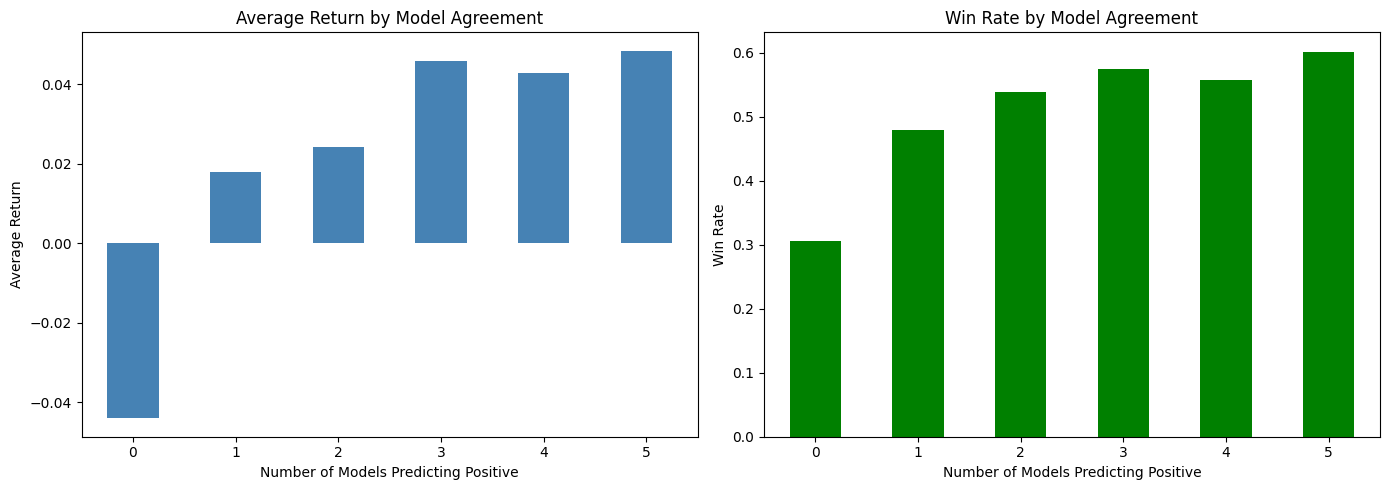

In [119]:
# Signal Quality by Ensemble Agreement
print("="*50 + "\nSIGNAL QUALITY BY MODEL AGREEMENT\n" + "="*50)

# Count how many models agree on positive prediction
test_df['models_agree_positive'] = (
    (test_df['cat_prob'] > 0.5).astype(int) +
    (test_df['xgb_pred'] > 0).astype(int) +
    (test_df['lgbm_pred'] > 0).astype(int) +
    (test_df['quantile_pred'] > 0).astype(int) +
    (test_df['ridge_pred'] > 0).astype(int)
)

agreement_analysis = test_df.groupby('models_agree_positive').agg({
    'return_30d_clipped': ['mean', 'std', 'count'],
    'is_profitable': 'mean'
}).round(4)
agreement_analysis.columns = ['Avg Return', 'Std', 'Count', 'Win Rate']
print("\nReturns by Number of Models Agreeing (Positive):")
print(agreement_analysis)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

agreement_analysis['Avg Return'].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Average Return by Model Agreement')
axes[0].set_xlabel('Number of Models Predicting Positive')
axes[0].set_ylabel('Average Return')
axes[0].tick_params(axis='x', rotation=0)

agreement_analysis['Win Rate'].plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title('Win Rate by Model Agreement')
axes[1].set_xlabel('Number of Models Predicting Positive')
axes[1].set_ylabel('Win Rate')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout(); plt.savefig('model_agreement.png', dpi=150); plt.show()